In [14]:
import scipy
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import deconvolve, convolve

Скачаем файлики по ссылкам, указанным в начале [домашенго задания](https://github.com/girafe-ai/dsp/blob/master/домашка/module1lecture2.md) и положим в папочку ```records``` (```sweeper.wav```, ```white_noise.wav```, ```pink_noise.wav```).
Преобразовать файлы в формат ```wav``` можно [здесь](https://convertio.co)

In [15]:
PROJECT_FOLDER = '/Users/ruadld6/Documents/dsp'

Воспроизведем файл со свипером согласно пункту 1. Запись положим в файл ```recorded_sweeper.wav```

In [16]:
orig, sr = sf.read(f'{PROJECT_FOLDER}/records/sweeper.wav')
reverb, _ = sf.read(f'{PROJECT_FOLDER}/records/recorded_sweeper.wav')


Так как тестовый свипер многоканальный, возьмем только первый массив значений

In [17]:
x = orig[:, 0]
y = reverb

print(x.shape)
print(y.shape)

(960960,)
(1228800,)


Эта функция считает скалярный произведения всех возможных сдвигов двух массивов и определяет аргмаксимум. Описание алгоритма можно найти на [сайте](https://e-maxx.ru/algo/fft_multiply) (раздел ```всевозможные скалярные произведения```). Предполагается, что корректный сдвиг будет достигаться там, где скалярное произведение максимально. Однако из-за сдвинутой дискретизации сигнала зачения могут быть шумными, поэтому можно посмотреть на график и руками выбрать параметр ```threshold```.

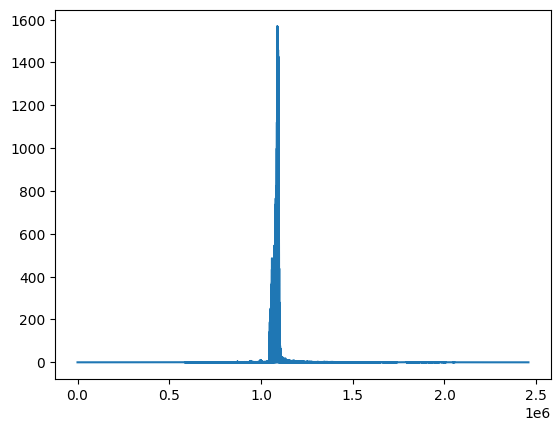

In [18]:
def cut_audio_by_template(x_, y_, threshold=None):
    x_fft = np.fft.fft(x_[::-1], n=2 * y_.shape[0])
    y_fft = np.fft.fft(y_, n=2 * y_.shape[0])
    
    mult_fft = x_fft * y_fft
    mult = np.fft.ifft(mult_fft)

    plt.plot(np.abs(mult))
    if threshold is None:
        shift = np.argmax(mult) - x_.shape[0]
    else:
        shift = np.argmax(mult > threshold)
    y_ = y_[shift: shift + x_.shape[0]]
    assert x_.shape == y_.shape

    return y_

y = cut_audio_by_template(x, y)

Посчитаем fft для обоих сигналов (пункт 2)

In [20]:
SAMPLE_RATE = 48000

frequencies = np.fft.rfftfreq(x.shape[0], 1 / SAMPLE_RATE)

x_fft = np.abs(np.fft.rfft(x))
y_fft = np.abs(np.fft.rfft(y))

Разобьем частотный отклик на чанки (пункты 3-5). В описании свипера сказано, что максимальная частота $20kHz$, однако при со значимыми значениями амплитуды выходит только $16kHz$

In [22]:
N_CHUNCKS = 32
MAX_FREQ = 16_000
MIN_FREQ = 20

x_fft_split = np.array_split(x_fft[(20 <= frequencies) & (frequencies <= MAX_FREQ)], N_CHUNCKS)
y_fft_split = np.array_split(y_fft[(20 <= frequencies) & (frequencies <= MAX_FREQ)], N_CHUNCKS)

freq_split = np.array_split(frequencies[(20 <= frequencies) & (frequencies <= MAX_FREQ)], N_CHUNCKS)


In [23]:
x_mean_power = np.array([np.mean(arr) for arr in x_fft_split])
y_mean_power = np.array([np.mean(arr) for arr in y_fft_split])

Получаем набор гейнов эквалайзера и нормируем на среднее значение, чтобы не учитывать громкость. (пункт 6)

In [24]:
eq_rate = y_mean_power / x_mean_power

In [25]:
eq_rate /= eq_rate.mean()

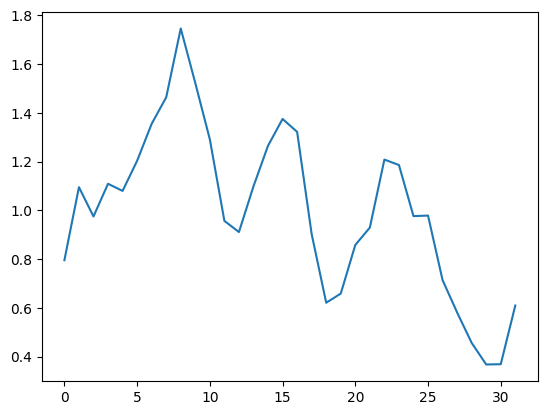

In [169]:
plt.plot(eq_rate)

Загружаем белый шум.

In [26]:
white_noise, _ = sf.read(f'{PROJECT_FOLDER}/records/white_noise.wav')
white_noise.shape

(240000, 2)

In [27]:
white_noise = white_noise[:, 0]

In [28]:
wn_frequencies = np.fft.rfftfreq(white_noise.shape[0], 1 / SAMPLE_RATE)

wn_fft = np.abs(np.fft.rfft(white_noise))

Нормируем белый шум на гейны эквалайзера. (пункт 7)

In [29]:
wn_fft_adjusted = wn_fft.copy()

for i in range(N_CHUNCKS):
    wn_fft_adjusted[
        (wn_frequencies >= freq_split[i][0]) &
        (wn_frequencies <= freq_split[i][-1])
    ] /= eq_rate[i]

Воспроизводим и записываем измененный шум. (пункты 8-9)

In [30]:
wn_adjusted = np.fft.irfft(wn_fft_adjusted)

sf.write(f'{PROJECT_FOLDER}/records/white_noise_adjusted.wav', wn_adjusted, SAMPLE_RATE, format='WAV')

In [31]:
white_noise_recorded, _ = sf.read(f'{PROJECT_FOLDER}/records/white_noise_recorded.wav')
white_noise_recorded.shape

(352256,)

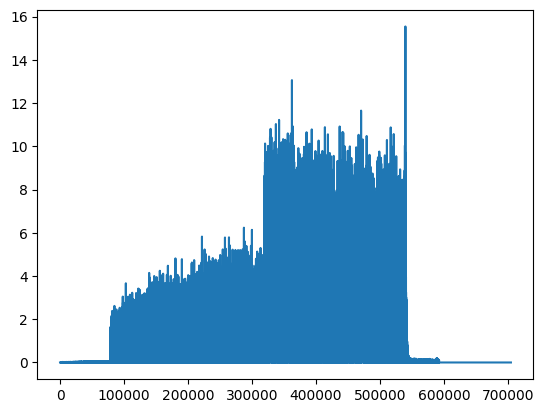

In [32]:
white_noise_recorded = cut_audio_by_template(wn_adjusted, white_noise_recorded, 1)

Сворачиваем записанный шум с оригинальным для получения отклика помещения (пункты 10-11)

In [33]:
conv = deconvolve(white_noise_recorded, white_noise)

In [34]:
conv

(array([-0.04846093]),
 array([ 0.        , -0.03668455,  0.01962727, ...,  0.02468717,
         0.0181633 ,  0.02929653]))

Выполняем пункты 1-4 из раздела **Что с ним теперь делать**

In [35]:
test, _ = sf.read(f'{PROJECT_FOLDER}/records/test.wav')
test_recorded, _ = sf.read(f'{PROJECT_FOLDER}/records/test_recorded.wav')

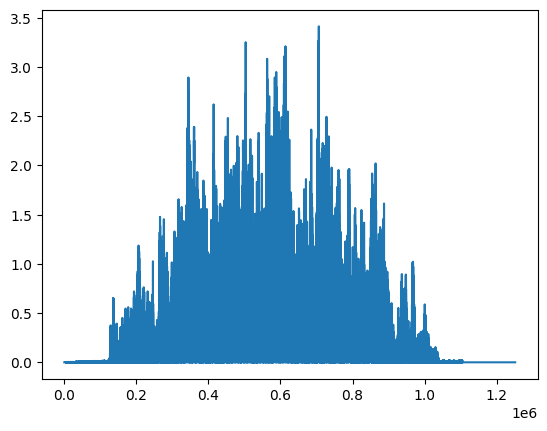

In [36]:
test_recorded = cut_audio_by_template(test, test_recorded, 0.2)

In [37]:
test_corrected = convolve(test_recorded, conv[0])

In [38]:
sf.write(f'{PROJECT_FOLDER}/records/test_corrected.wav', test_corrected, SAMPLE_RATE, format='WAV')

Полученный файл звучит чище, чем записанный с колонки. Однако, он получилось заметно тише, чем оригинал. Возможно стоит повнимательнее учитывать нормировочный коэффициент.

### Наслаждаемся проделанной работой!

### ДЗ 2

Напишем функцию для смешивания сигнала с шумом с заданным значением SNR.
Напомним, что:
$$SNR = \frac{P_{signal}}{P_{noise}} = \frac{A_{signal}^2}{A_{noise}^2}$$
$$SNR_{dB} = 10 \log_{10} SNR = 20 log_{10} \frac{A_{signal}}{A_{noise}}$$

In [85]:
def mixer(original, noise, snr_db):
    # Сделаем длину шума равной длиней сигнала
    noise = noise[np.arange(len(original)) % len(noise)]

    # Считаем амплитуды
    signal_mean = np.mean(original ** 2)
    noise_mean = np.mean(noise ** 2)

    noise = noise * np.sqrt(signal_mean / noise_mean)

    linear_snr = np.exp(snr_db / 20 * np.log(10))

    # Считаем коэффициенты из предположения, что средняя амплитуда не должна измениться
    signal_coef = linear_snr / (1 + linear_snr)
    noise_coef = 1 / (1 + linear_snr)

    mix = signal_coef * original + noise_coef * noise
    
    return mix

Скачаем шум [здесь](https://freesound.org/people/15GPanskaHladikova_Danuse/sounds/461143/)

In [86]:
noise, _ = sf.read(f'{PROJECT_FOLDER}/records/noise.wav')
signal, _ = sf.read(f'{PROJECT_FOLDER}/records/test.wav')

In [87]:
for snr_db in [-5, 0, 5, 10]:
    mix = mixer(signal, noise[:, 0], snr_db)
    sf.write(f'{PROJECT_FOLDER}/records/test_{snr_db}dB.wav', mix, SAMPLE_RATE, format='WAV')

Посчитаем необходимые метрики.

Необходимо установить ```torchmetrics``` и отдельно ```pesq```
1. ```pip3 install torchmetrics```
2. ```pip3 install pesq``` или ```pip install torchmetrics[audio]```

In [88]:
import torch
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
from torchmetrics.audio import SignalDistortionRatio

# Добавим библиотеку librosa для чтения файлов и даунсемплинга. Пригодится для метрики PESQ
import librosa

In [155]:
result_df = pd.DataFrame()

In [156]:
result_df['file'] = ['test.wav'] + [f'test_{snr_db}dB.wav' for snr_db in [-5, 0, 5, 10]]
result_df['SNR'] = [np.inf, -5, 0, 5, 10]

Напишем шаблонную функцию для расчета метрик.

In [157]:
def calculate_metric(original_signal, metrics_df, metric_name, metric_class):
    metric_array = []
    
    for file in metrics_df['file']:
        cur_signal, _ = sf.read(f'{PROJECT_FOLDER}/records/{file}')
        metric = metric_class()
        metric_array.append(float(metric(torch.from_numpy(original_signal), torch.from_numpy(cur_signal))))

    metrics_df[metric_name] = metric_array

In [158]:
calculate_metric(signal, result_df, 'SDR', SignalDistortionRatio)
calculate_metric(signal, result_df, 'SI-SDR', ScaleInvariantSignalDistortionRatio)


Для использования метрики ```pesq``` необходимо понизить частоту до $16kHz$.

In [159]:
pesq_array = []

downsampled_signal, _ = librosa.load(f'{PROJECT_FOLDER}/records/test.wav', sr=16000)
for file in result_df['file']:
    cur_signal, _ = librosa.load(f'{PROJECT_FOLDER}/records/{file}', sr=16000)
    pesq = PerceptualEvaluationSpeechQuality(16000, 'nb')
    pesq_array.append(float(pesq(torch.from_numpy(downsampled_signal), torch.from_numpy(cur_signal))))

result_df['PESQ'] = pesq_array

In [160]:
result_df

file   SNR         SDR      SI-SDR      PESQ
0       test.wav   inf  159.545898  189.229599  4.548638
1  test_-5dB.wav  -5.0   -3.011709   -5.044806  1.035639
2   test_0dB.wav   0.0    1.239064   -0.025154  1.053364
3   test_5dB.wav   5.0    5.679022    4.985884  1.103212
4  test_10dB.wav  10.0   10.320993    9.992079  1.245525

Склонируем NISQA: ```git clone https://github.com/gabrielmittag/NISQA.git```

Установим env: ```conda env create -f env.yml```

Активируем env: ```conda activate nisqa```

Сохраним список файлов и запустим расчет метрик: ```python3 run_predict.py --mode predict_csv --pretrained_model weights/nisqa.tar --csv_file path/to/csv/file  --csv_deg column_name --num_workers 0 --bs 10 --output_dir path/to/save/metrics```

In [161]:
files_df = result_df[['file']]
files_df['file'] = PROJECT_FOLDER + '/records/' + files_df['file']
files_df.to_csv('files.csv')

/var/folders/0p/mm7pdq6n4kq68cl8nw_gp3j82tkhys/T/ipykernel_30329/3379418415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files_df['file'] = PROJECT_FOLDER + '/records/' + files_df['file']


In [162]:
nisqa_df = pd.read_csv('records/NISQA_results.csv')
nisqa_df['file'] = nisqa_df['file'].apply(lambda x: x.split('/')[-1])

In [163]:
result_df = result_df.merge(
    nisqa_df.drop(
        ['Unnamed: 0', 
         'model'
        ], axis=1), left_on='file', right_on='file')

Для метрики [DNSMOS](https://github.com/microsoft/DNS-Challenge/tree/master/DNSMOS), чтобы не клонировать весь репозиторий, необходимо скачать следующие файлы: [dnsmos_local.py](https://github.com/microsoft/DNS-Challenge/blob/master/DNSMOS/dnsmos_local.py), [requirements.txt](https://github.com/microsoft/DNS-Challenge/tree/master/DNSMOS/DNSMOS) и папку с моделями [DNSMOS](https://github.com/microsoft/DNS-Challenge/tree/master/DNSMOS/DNSMOS).

Далее необходимо создать энв, в котором установить ```requirements.txt```.

Для оценки метрики можно воспользоваться следующей командой: ```python3 dnsmos_local.py -t path/to/audios -o sample.csv```

Если установить энв не получилось и версия библиотеки ```librosa``` новее указанной в ```requirements.txt```, то можно в файле ```dnsmos_local.py``` заменить строчку ```audio = librosa.resample(aud, input_fs, fs)``` на ```audio = librosa.resample(aud, orig_sr=input_fs, target_sr=fs)```

In [164]:
dnsmos_df = pd.read_csv('sample.csv')
dnsmos_df.head()

Unnamed: 0                          filename  len_in_sec     sr  num_hops  \
0           0     records/enhanced_test_0dB.wav        10.0  16000         1   
1           1                  records/test.wav        10.0  16000         1   
2           2  records/white_noise_adjusted.wav         5.0  16000         1   
3           3    records/enhanced_test_10dB.wav        10.0  16000         1   
4           4              records/test_5dB.wav        10.0  16000         1   

   OVRL_raw   SIG_raw   BAK_raw      OVRL       SIG       BAK  P808_MOS  
0  2.937405  3.206793  3.886512  2.738779  3.056688  3.869100  3.593476  
1  4.041115  4.210765  4.539121  3.448771  3.657029  4.195249  4.146636  
2  0.987248  1.014740  1.014884  1.081318  1.157612  1.101443  2.154828  
3  3.870535  4.021890  4.513235  3.349811  3.557016  4.184448  4.035709  
4  2.147224  3.713479  1.836731  2.129214  3.380827  2.115344  2.515635

In [165]:
dnsmos_df['filename'] = dnsmos_df['filename'].apply(lambda x: x.split('/')[-1])

In [166]:
result_df = result_df.merge(dnsmos_df.drop(['Unnamed: 0', 'len_in_sec', 'sr', 'num_hops'], axis=1), left_on='file', right_on='filename').drop('filename', axis=1)

Теперь добавим собственную оценку (метрику MOS)

In [167]:
result_df['MOS'] = [5, 1, 1, 2, 2]

In [168]:
result_df

file   SNR         SDR      SI-SDR      PESQ  mos_pred  noi_pred  \
0       test.wav   inf  159.545898  189.229599  4.548638  4.706658  4.499089   
1  test_-5dB.wav  -5.0   -3.011709   -5.044806  1.035639  0.912774  1.302374   
2   test_0dB.wav   0.0    1.239064   -0.025154  1.053364  1.632286  1.347787   
3   test_5dB.wav   5.0    5.679022    4.985884  1.103212  2.057696  1.445465   
4  test_10dB.wav  10.0   10.320993    9.992079  1.245525  2.312069  1.590357   

   dis_pred  col_pred  loud_pred  OVRL_raw   SIG_raw   BAK_raw      OVRL  \
0  4.600805  4.408635   4.547240  4.041115  4.210765  4.539121  3.448771   
1  3.484320  2.032331   1.818125  1.070375  1.061558  0.992080  1.162469   
2  4.297644  2.954377   2.634257  1.431136  2.205391  1.240492  1.503823   
3  4.409371  3.516179   3.278281  2.147224  3.713479  1.836731  2.129214   
4  4.491841  3.960564   3.528837  2.556641  4.040444  2.236337  2.455596   

        SIG       BAK  P808_MOS  MOS  
0  3.657029  4.195249  4.146636    5  
1  1.206607  1.070773  2.412814    1  
2  2.289250  1.397484  2.421385    1  
3  3.380827  2.115344  2.515635    2  
4  3.567106  2.544065  2.743795    2

Заметим, что значения метрик ```SDR```  и ```SI-SDR``` хорошо скоррелированы со значениями ```SNR``` что согласуется с теортическим результатми. Остальные метрики ранжируют файлы в порядке увеличения ```SNR```. Наиболее согласующимеися с моим восприятием являются метрики ```OVRL``` и ```BAK```.

### ДЗ 3

Установим библиотеку [DeepFilterNet](https://github.com/Rikorose/DeepFilterNet/tree/main)
1. ```pip3 install torch torchaudio -f https://download.pytorch.org/whl/cpu/torch_stable.html```
2. ```pip3 install deepfilternet```

Очистим от шума сгенерированные файлы при помощи этой модели.

In [100]:
from df.enhance import enhance, init_df, load_audio, save_audio

for file in result_df['file']:
    model, df_state, _ = init_df()  # Load default model
    noisy_audio, _ = load_audio(f'{PROJECT_FOLDER}/records/{file}', sr=df_state.sr())
    
    enhanced_audio = enhance(model, df_state, noisy_audio)
    
    save_audio(f'{PROJECT_FOLDER}/records/enhanced_{file}', enhanced_audio, df_state.sr())

2023-12-17 20:07:01 | INFO     | DF | Loading model settings of DeepFilterNet3
2023-12-17 20:07:01 | INFO     | DF | Using DeepFilterNet3 model at /Users/ruadld6/Library/Caches/DeepFilterNet/DeepFilterNet3
2023-12-17 20:07:01 | INFO     | DF | Initializing model `deepfilternet3`
2023-12-17 20:07:01 | INFO     | DF | Found checkpoint /Users/ruadld6/Library/Caches/DeepFilterNet/DeepFilterNet3/checkpoints/model_120.ckpt.best with epoch 120
2023-12-17 20:07:01 | INFO     | DF | Running on device cpu
2023-12-17 20:07:01 | INFO     | DF | Model loaded
2023-12-17 20:07:02 | INFO     | DF | Loading model settings of DeepFilterNet3
2023-12-17 20:07:02 | INFO     | DF | Using DeepFilterNet3 model at /Users/ruadld6/Library/Caches/DeepFilterNet/DeepFilterNet3
2023-12-17 20:07:02 | INFO     | DF | Initializing model `deepfilternet3`
2023-12-17 20:07:02 | INFO     | DF | Found checkpoint /Users/ruadld6/Library/Caches/DeepFilterNet/DeepFilterNet3/checkpoints/model_120.ckpt.best with epoch 120
2023-12

Посчитаем метрики для обновленных файлов

In [144]:
enhanced_result_df = pd.DataFrame()

In [145]:
enhanced_result_df['file'] = ['enhanced_' + filename for filename in result_df['file']]
enhanced_result_df['SNR'] = [None] * 5

In [146]:
calculate_metric(signal, enhanced_result_df, 'SDR', SignalDistortionRatio)
calculate_metric(signal, enhanced_result_df, 'SI-SDR', ScaleInvariantSignalDistortionRatio)

In [147]:
pesq_array = []

downsampled_signal, _ = librosa.load(f'{PROJECT_FOLDER}/records/test.wav', sr=16000)
for file in enhanced_result_df['file']:
    cur_signal, _ = librosa.load(f'{PROJECT_FOLDER}/records/{file}', sr=16000)
    pesq = PerceptualEvaluationSpeechQuality(16000, 'nb')
    pesq_array.append(float(pesq(torch.from_numpy(downsampled_signal), torch.from_numpy(cur_signal))))

enhanced_result_df['PESQ'] = pesq_array

In [148]:
enhanced_result_df

file   SNR        SDR     SI-SDR      PESQ
0       enhanced_test.wav  None  36.513866  35.653992  4.526783
1  enhanced_test_-5dB.wav  None   4.370720   4.150445  1.436692
2   enhanced_test_0dB.wav  None   9.042878   8.878994  1.870655
3   enhanced_test_5dB.wav  None  12.866441  12.745543  2.507097
4  enhanced_test_10dB.wav  None  16.349615  16.246706  2.915400

In [149]:
enhanced_files_df = enhanced_result_df[['file']]
enhanced_files_df['file'] = PROJECT_FOLDER + '/records/' + enhanced_files_df['file']
enhanced_files_df.to_csv('enhanced_files.csv')

/var/folders/0p/mm7pdq6n4kq68cl8nw_gp3j82tkhys/T/ipykernel_30329/935113656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enhanced_files_df['file'] = PROJECT_FOLDER + '/records/' + enhanced_files_df['file']


In [150]:
nisqa_df = pd.read_csv('records/NISQA_results.csv')
nisqa_df['file'] = nisqa_df['file'].apply(lambda x: x.split('/')[-1])

In [151]:
enhanced_result_df = enhanced_result_df.merge(
    nisqa_df.drop(
        ['Unnamed: 0', 
         'model'
        ], axis=1), left_on='file', right_on='file')

In [152]:
enhanced_result_df = enhanced_result_df.merge(dnsmos_df.drop(['Unnamed: 0', 'len_in_sec', 'sr', 'num_hops'], axis=1), left_on='file', right_on='filename').drop('filename', axis=1)

In [153]:
enhanced_result_df['MOS'] = [5, 3, 3, 4, 5]

In [154]:
enhanced_result_df

file   SNR        SDR     SI-SDR      PESQ  mos_pred  \
0       enhanced_test.wav  None  36.513866  35.653992  4.526783  4.891985   
1  enhanced_test_-5dB.wav  None   4.370720   4.150445  1.436692  2.973378   
2   enhanced_test_0dB.wav  None   9.042878   8.878994  1.870655  4.114570   
3   enhanced_test_5dB.wav  None  12.866441  12.745543  2.507097  4.310879   
4  enhanced_test_10dB.wav  None  16.349615  16.246706  2.915400  4.447963   

   noi_pred  dis_pred  col_pred  loud_pred  OVRL_raw   SIG_raw   BAK_raw  \
0  4.652639  4.750799  4.525504   4.689176  4.080356  4.229570  4.600469   
1  3.746526  3.243279  3.001042   2.889406  2.298578  2.461215  3.744405   
2  4.197452  4.294521  4.160993   4.112768  2.937405  3.206793  3.886512   
3  4.212479  4.462261  4.247647   4.368663  3.717492  3.872866  4.466243   
4  4.251384  4.510139  4.227479   4.404746  3.870535  4.021890  4.513235   

       OVRL       SIG       BAK  P808_MOS  MOS  
0  3.470979  3.666659  4.220141  4.131906    5  
1  2.252514  2.501321  3.783211  3.153647    3  
2  2.738779  3.056688  3.869100  3.593476    3  
3  3.257673  3.473876  4.164390  3.893647    4  
4  3.349811  3.557016  4.184448  4.035709    5

Заметим, что и по значениям алгоритмически посчитанных метрик, и на слух качество сильно улучшилось после использования шумадава. НЕсмотря на это многие метрики перестали различать файлы, где исходное значение ```SNR``` находится в диапазоне $0-10dB$. 